In [59]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#Imports
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from random import gauss as gs
import datetime

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [60]:
df = pd.read_csv('rollingsales_brooklyn.xls_prepped_bare.csv')

In [61]:
df.reset_index(drop=True)

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
0,1,11228.0,1300000,2020-04-28
1,1,11228.0,75000,2020-11-30
2,1,11214.0,830000,2020-06-26
3,1,11214.0,1188000,2020-07-20
4,1,11214.0,990000,2021-02-22
...,...,...,...,...
11619,4,11237.0,470000,2020-12-01
11620,4,11237.0,15000,2021-02-18
11621,4,11237.0,600000,2021-02-12
11622,4,11237.0,900000,2020-11-19


In [62]:
df['SALE DATE']= pd.to_datetime(df['SALE DATE'])
df=df.sort_values(by='SALE DATE')

In [63]:
type(df['SALE DATE'][2])

pandas._libs.tslibs.timestamps.Timestamp

In [64]:
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])

In [65]:
df_price_date = df_price_date.set_index('SALE DATE')

In [66]:
# df_price_date.index.unique

In [67]:
#group by day
df_price_date = df_price_date.resample('D').mean()

In [68]:
df_price_date['SALE PRICE']=df_price_date['SALE PRICE'].fillna(0)

In [69]:
df_price_date.dropna(inplace=True)

In [70]:
df_price_date.loc[(df_price_date!=0).any(1)]

,SALE PRICE
SALE DATE,
2020-04-01,3.977437e+06
2020-04-02,8.185471e+05
2020-04-03,1.815030e+06
2020-04-04,2.333627e+05
2020-04-06,8.709561e+05
...,...
2021-03-25,1.216184e+06
2021-03-26,1.064060e+06
2021-03-29,1.002984e+06


In [71]:
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=30)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [72]:
register_matplotlib_converters()

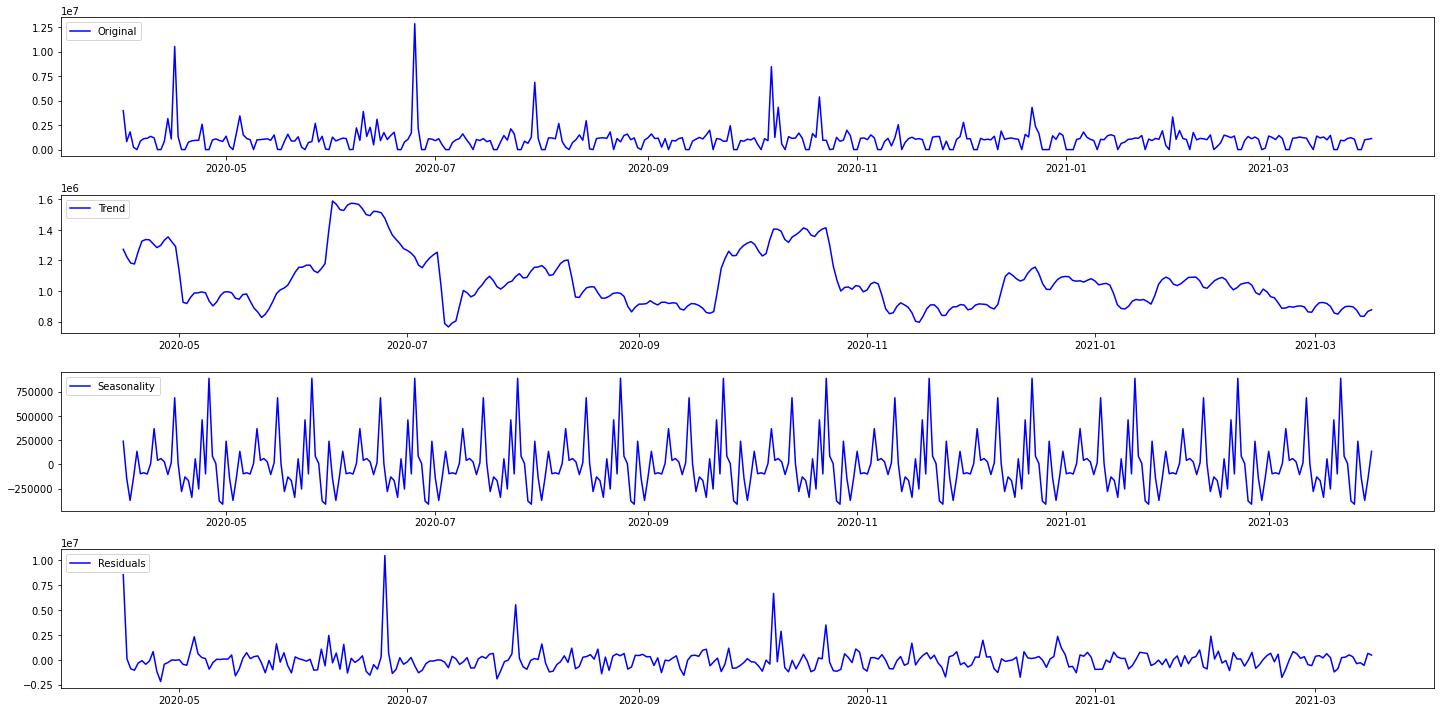

In [73]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [74]:
# df_price_date['roll_avg'] = df_price_date['SALE PRICE'].rolling(window=5).mean()

In [75]:
# df_price_date

In [76]:
# plt.figure(figsize=(20, 10))
# plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
# plt.scatter(df_price_date.index[4:365], df_price_date['roll_avg'][4:365], s=20);

In [77]:
# lr = LinearRegression()
# lr.fit(df_price_date[['roll_avg']][4:], df_price_date['SALE PRICE'][4:])

In [78]:
# plt.figure(figsize=(20, 10))
# plt.plot(df_price_date.index[:265], df_price_date['SALE PRICE'][:265], label='Data')
# plt.plot(df_price_date.index[4:265], lr.predict(df_price_date[['roll_avg']][4:265]),
#          label='Predicted')
# plt.legend();

In [79]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-4.665875408357549, 9.749187516484523e-05, 15, 349, {'1%': -3.449226932880019, '5%': -2.869857365438656, '10%': -2.571201085130664}, 10619.45547609437)

Test Statistic                  -4.665875
p-value                          0.000097
#Lags Used                      15.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


In [80]:
#differencing to remove seasonality period 12 rolling mean
df_price_date_diff= df_price_date.diff(periods=30)
df_price_date_diff.dropna(inplace=True)
df_price_date_diff.reset_index(drop=True)


,SALE PRICE
0,-2.610853e+06
1,-4.885471e+05
2,-1.815030e+06
3,1.443967e+06
4,3.443755e+06
...,...
330,-1.283914e+06
331,-1.069368e+06
332,1.002984e+06
333,9.138573e+05


In [81]:
df_price_date = df_price_date - df_price_date_diff

In [82]:
df_price_date.dropna(inplace=True)

In [83]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-4.577651950516628, 0.0001419914030504462, 15, 319, {'1%': -3.4510167751522642, '5%': -2.87064334231426, '10%': -2.5716201744283174}, 9729.168919290358)

Test Statistic                  -4.577652
p-value                          0.000142
#Lags Used                      15.000000
Number of Observations Used    319.000000
Critical Value (1%)             -3.451017
Critical Value (5%)             -2.870643
Critical Value (10%)            -2.571620
dtype: float64


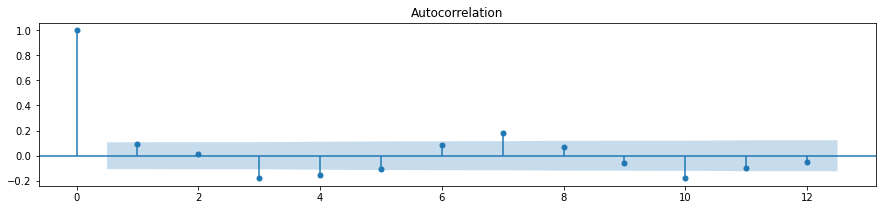

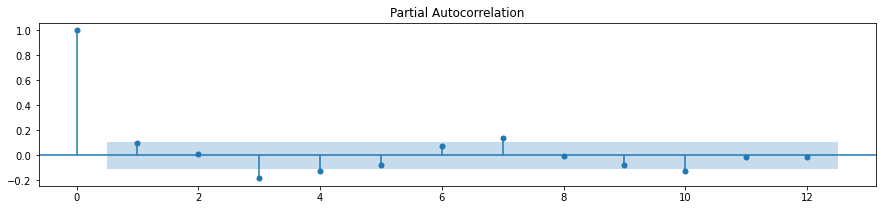

In [84]:
rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date, lags=12, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date, lags=12, alpha=0.05);

In [85]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
#about 2/3 of the way between 25 and 50, 2/3 of 25 is roughly 17. Ill say 25 + 17 = 42
p = 7

 # q = lagged forecast errors - PACF
    
q = 7


# Fitting ARMA model and summary
ar = ARMA(df_price_date,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  335
Model:                     ARMA(7, 7)   Log Likelihood               -5146.241
Method:                       css-mle   S.D. of innovations        1114141.635
Date:                Sat, 12 Jun 2021   AIC                          10324.481
Time:                        21:54:15   BIC                          10385.507
Sample:                    05-01-2020   HQIC                         10348.810
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.087e+06   2.35e+04     46.313      0.000    1.04e+06    1.13e+06
ar.L1.SALE PRICE    -0.4966      0.011    -45.750      0.000      -0.518      -0.475
ar.L2.SALE PRICE     0.4210      0.018     23.287      0.000       0.386       0.456
ar.L3.SALE PRICE    -0.0927      0.012     -7.616      0.000      -0.117      -0.069
ar.L4.SALE PRICE    -0.0087      0.010     -0.867      0.386      -0.028       0.011
ar.L5.SALE PRICE    -0.3718      0.012    -31.705      0.000      -0.395      -0.349
ar.L6.SALE PRICE     0.4658        nan        nan        nan         nan         nan
ar.L7.SALE PRICE     0.9386        nan        nan        nan         nan         nan
ma.L1.SALE PRICE     0.4768      0.016     29.372      0.000       0.445       0.509
ma.L2.SALE PRICE    -0.4088      0.020    -20.669      0.000      -0.448      -0.370
ma.L3.SALE PRICE     0.0608      0.019      3.216      0.001       0.024       0.098
ma.L4.SALE PRICE    -0.0608      0.020     -3.073      0.002      -0.100      -0.022
ma.L5.SALE PRICE     0.4088      0.022     18.357      0.000       0.365       0.452
ma.L6.SALE PRICE    -0.4768      0.014    -34.707      0.000      -0.504      -0.450
ma.L7.SALE PRICE    -1.0000      0.020    -49.566      0.000      -1.040      -0.960
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0181           -0.0000j            1.0181           -0.0000
AR.2            0.6220           -0.7830j            1.0000           -0.1432
AR.3            0.6220           +0.7830j            1.0000            0.1432
AR.4           -0.3850           -0.9471j            1.0223           -0.3114
AR.5           -0.3850           +0.9471j            1.0223            0.3114
AR.6           -0.9943           -0.1126j            1.0006           -0.4821
AR.7           -0.9943           +0.1126j            1.0006            0.4821
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.6234           -0.7819j            1.0000           -0.1429
MA.3            0.6234           +0.7819j            1.0000            0.1429
MA.4           -0.3683           -0.9297j            1.0000           -0.3100
MA.5           -0.3683           +0.9297j            1.0000            0.3100
MA.6           -0.9935           -0.1142j            1.0000           -0.4818
MA.7           -0.9935           +0.1142j            1.0000            0.4818
-----------------------------------------------------------------------------
"""

In [86]:
r2_score(df_price_date, ar.predict())

0.16880650848902135

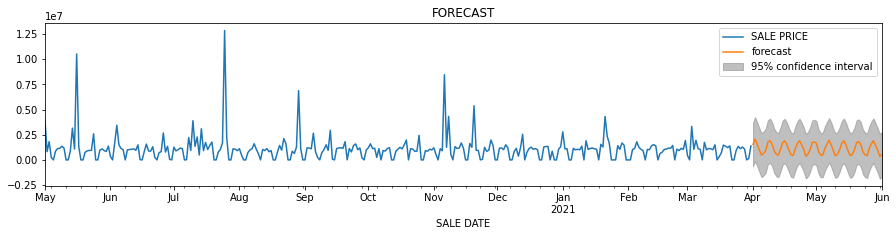

In [87]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = df_price_date.plot(ax=ax, title='FORECAST')
fig = ar.plot_predict('2021-04-01', '2021-06-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()

In [ ]:
scateer rather than line